In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import nearest_points, snap
import numpy as np
import time
from shapely.ops import unary_union
import fiona


In [414]:
mapbox_crs = 'EPSG:4326'

In [415]:
# read in parcels data
parcels = gpd.read_file("shp/ParcelData.gdb")

# read in zoning data
zoning = gpd.read_file("shp/zoning/zoning.shp")

# read in structures data
structures = gpd.read_file("shp/structures_poly_160/structures_poly_160.shp")

# read in ROW data
roads = gpd.read_file("shp/MassDOTRoads.gdb")

# read in zoning dimensional requirements
zoning_df = pd.read_csv("nonconformity_analysis/Zoning Dimensional Requirements.csv")

In [ ]:
Mass_parcels = gpd.read_file("shp/MassGIS_L3_Parcels_gdb/MassGIS_L3_Parcels.gdb", layer='L3_TAXPAR_POLY')
Mass_parcels = Mass_parcels.to_crs(parcels.crs)
print(Mass_parcels.columns)
# row = Mass_parcels[Mass_parcels['CODE'].str.contains('ROW')]


# # List all layers in the geodatabase
# layers = fiona.listlayers("shp/MassGIS_L3_Parcels_gdb/MassGIS_L3_Parcels.gdb")
# print("Available layers:")
# for layer in layers:
#     print(f"  - {layer}")

/Users/mckenziehumann/Documents/CommunityScale/Lowell/.venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(


Index(['MAP_PAR_ID', 'LOC_ID', 'POLY_TYPE', 'MAP_NO', 'SOURCE', 'PLAN_ID',
       'LAST_EDIT', 'BND_CHK', 'NO_MATCH', 'TOWN_ID', 'SITE', 'ESN',
       'LU_CODES', 'DEV', 'SYM1', 'SYM2', 'SHAPE_Length', 'SHAPE_Area',
       'geometry'],
      dtype='object')
Available layers:
  - L3_LUT
  - L3_UC_LUT
  - L3_ASSESS
  - L3_MISC_POLY
  - L3_OTHLEG_POLY
  - L3_PARCEL_FTP_LINKS
  - L3_TOWNFY
  - L3_TAXPAR_POLY


In [307]:
towns_outline = gpd.read_file("shp/townssurvey_gdb/townssurvey.gdb", layer="TOWNSSURVEY_POLYM")
# towns_outline
lowell_outline = towns_outline[towns_outline['TOWN']=='LOWELL']
lowell_outline_mapbox = lowell_outline.to_crs(mapbox_crs)
lowell_outline
lowell_outline_mapbox.to_file("../Lowell-git/lowell_outline.geojson", driver="GeoJSON")

In [426]:
# ensure all datasets use the same coordinate reference system
print(parcels.crs)
print(zoning.crs)
print(structures.crs)
print(roads.crs)
print(Mass_parcels.crs)

EPSG:26986
PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",41],PARAMETER["central_meridian",-71.5],PARAMETER["standard_parallel_1",41.7166666666667],PARAMETER["standard_parallel_2",42.6833333333333],PARAMETER["false_easting",656166.666666667],PARAMETER["false_northing",2460625],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
EPSG:26986
EPSG:3857
EPSG:26986


In [427]:
zoning = zoning.to_crs(parcels.crs)
roads = roads.to_crs(parcels.crs)
Mass_parcels = Mass_parcels.to_crs(parcels.crs)


In [428]:
duplicates = parcels[parcels.duplicated(subset=['LOC_ID'], keep=False)]
print(f"Found {len(duplicates)} duplicate LOC_IDs:")
print(duplicates['LOC_ID'].value_counts())

Found 0 duplicate LOC_IDs:
Series([], Name: count, dtype: int64)


In [444]:
parcels = parcels[parcels['City']=='Lowell']
roads = roads.clip(lowell_outline)

print(Mass_parcels['POLY_TYPE'].value_counts())
row = Mass_parcels[(Mass_parcels['POLY_TYPE']=='ROW') | (Mass_parcels['POLY_TYPE']=='PRIV_ROW')]
row = row.clip(lowell_outline)
# row = row.dissolve()

POLY_TYPE
FEE         2130788
TAX           48411
ROW            6243
PRIV_ROW       5037
WATER          4044
RAIL_ROW       1463
Name: count, dtype: int64


In [431]:
print(parcels.shape)
# print(parcels_lowell_clippped.shape)

(21934, 19)


In [432]:
roads.columns

Index(['STREETNAME', 'CLASS', 'ADMIN_TYPE', 'RT_NUMBER', 'ALTRTNUM1',
       'ALTRTNUM2', 'ALTRTNUM3', 'ALTRTNUM4', 'ALTRT1TYPE', 'RDTYPE',
       'ROUTE_ID', 'ROUTE_SYSTEM', 'ROUTE_NUMBER', 'ROUTE_DIRECTION',
       'RD_SEG_ID', 'STREET_NAME', 'FM_ST_NAME', 'TO_ST_NAME', 'FACILITY',
       'F_CLASS', 'URBAN_AREA', 'URBAN_TYPE', 'F_F_CLASS', 'JURISDICTN', 'NHS',
       'FD_AID_RTE', 'FD_AID_RD', 'CONTROL', 'NUM_LANES', 'OPP_LANES',
       'SURFACE_TP', 'SURFACE_WD', 'SHLDR_RT_W', 'SHLDR_RT_T', 'SHLDR_LT_W',
       'SHLDR_LT_T', 'SHLDR_UL_W', 'SHLDR_UL_T', 'MED_WIDTH', 'MED_TYPE',
       'CURB', 'LT_SIDEWLK', 'RT_SIDEWLK', 'OPERATION', 'SPEED_LIM',
       'OP_DIR_SL', 'TRUCK', 'T_EXC_TYPE', 'T_EXC_TIME', 'TRK_NETWRK',
       'TRUCK_RTE', 'ROW_WIDTH', 'STRUCT_CND', 'TERRAIN', 'TOLL_ROAD', 'MHS',
       'MGIS_TOWN', 'CITY', 'COUNTY', 'HWY_DIST', 'MPO', 'RPA', 'RTA',
       'MILE_COUNT', 'AADT', 'AADT_YEAR', 'AADT_DERIV', 'LENGTH_MI',
       'LENGTH_FT', 'GlobalID', 'SHAPE_Length', 'geomet

In [314]:
def roads_to_row_polygons(roads_gdf, width_column):
    """
    Convert road lines to ROW polygons based on width attribute
    
    Parameters:
    roads_gdf: GeoDataFrame with road line features
    width_column: string name of the column containing ROW width values
    
    Returns:
    GeoDataFrame with ROW polygons
    """
    
    # Make a copy to avoid modifying original
    row_polygons = roads_gdf.copy()
    
    # Buffer each road by half its width (width/2 on each side = full width)
    row_polygons.geometry = roads_gdf.geometry.buffer(
        roads_gdf[width_column] / 2 / 3.28084  # convert feet to meters if needed
    )
    
    return row_polygons

In [315]:
roads.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meter)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# print(roads['ROW_WIDTH'].describe())
# row = roads_to_row_polygons(roads, 'ROW_WIDTH')

count    3300.000000
mean       48.253939
std        27.842655
min        10.000000
25%        40.000000
50%        40.000000
75%        50.000000
max       300.000000
Name: ROW_WIDTH, dtype: float64


In [445]:
row

,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,NO_MATCH,TOWN_ID,SITE,ESN,LU_CODES,DEV,SYM1,SYM2,SHAPE_Length,SHAPE_Area,geometry
1164168,None,M_218373_930338,ROW,10,ASSESS,None,20121106,None,N,295,None,NaN,None,None,NaN,NaN,420.567297,3.728670e+03,"POLYGON ((218294.938 930284.461, 218294.938 93..."
1347753,1285-274,F_717220_3058040,ROW,268,ASSESS,None,20140701,None,N,160,None,NaN,None,None,NaN,NaN,138.509278,4.494806e+02,"POLYGON ((218586.633 932073.635, 218585.852 93..."
1659895,None,F_717028_3061857,ROW,None,ASSESS,None,20110720,None,N,160,None,NaN,None,None,NaN,NaN,430.172569,8.337532e+01,"POLYGON ((218526.264 933319.355, 218527.578 93..."
1747058,4960-161,F_715869_3062934,ROW,245,ASSESS,None,20110720,None,N,160,None,NaN,None,None,NaN,NaN,1289.187394,4.192252e+02,"POLYGON ((218186.716 933627.889, 218194.088 93..."
1775140,4960-223,F_716736_3062118,ROW,261,ASSESS,None,20110720,None,N,160,None,NaN,None,None,NaN,NaN,913.365133,3.246766e+02,"POLYGON ((218367.596 933694.412, 218372.454 93..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184715,None,F_710994_3066390,ROW,64,ASSESS,None,20110827,None,N,79,None,NaN,None,None,NaN,NaN,101.794614,4.898125e+02,"POLYGON ((216696.887 934625.742, 216690.879 93..."
1872346,1955-193.2,F_710445_3066872,ROW,192,ASSESS,None,20110720,None,N,160,None,NaN,None,None,NaN,NaN,367.781325,2.160136e+03,"POLYGON ((216623.016 934764.16, 216458.229 934..."
1876597,None,F_708433_3066976,ROW,171,OTHER,None,20140925,None,N,160,None,NaN,None,None,NaN,NaN,653.058148,3.804208e+03,"POLYGON ((215935.554 934663.983, 215923.038 93..."
2184717,None,F_707493_3067378,ROW,63,ASSESS,None,20110827,None,N,79,None,NaN,None,None,NaN,NaN,341.162851,1.858024e+03,"POLYGON ((215585.181 934882.524, 215585.192 93..."


In [ ]:
# # --- Subtract parcels from ROW to exclude overlapping areas ---
# # Remove empty ROW geometries first
# row = row[row.geometry.notnull()]

# # Combine all parcels into a single geometry
# parcels_union = parcels.geometry.unary_union

# # Subtract parcels from ROW safely
# row_no_parcels = row.copy()
# row_no_parcels['geometry'] = row_no_parcels.geometry.apply(
#     lambda g: g.difference(parcels_union) if g is not None else None
# )

# # Remove empty geometries after difference
# row_no_parcels = row_no_parcels[~row_no_parcels.is_empty]

/var/folders/8r/d33ysv4j5v74p1wd2nt7sq1h0000gn/T/ipykernel_1947/1499723622.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  parcels_union = parcels.geometry.unary_union


Text(0.5, 1.0, 'Lowell Parcels')

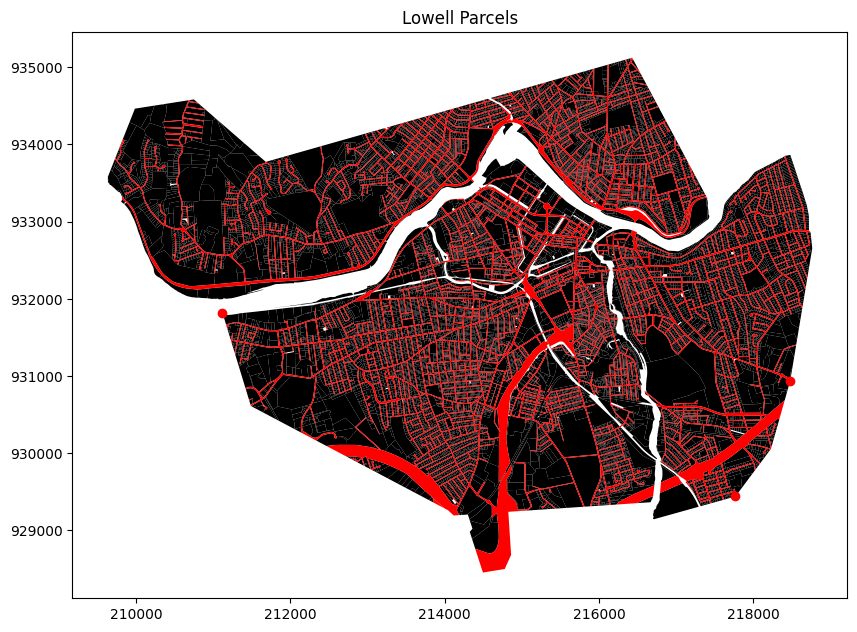

In [446]:
# plot to visually inspect lowell boundary
fig, ax = plt.subplots(figsize=(10, 10))
parcels.plot(ax=ax, color='black')
row.plot(ax=ax, color='red')
plt.title("Lowell Parcels")

Extracted subset sizes:
  Structures: 990
  Parcels: 847
  ROW: 2


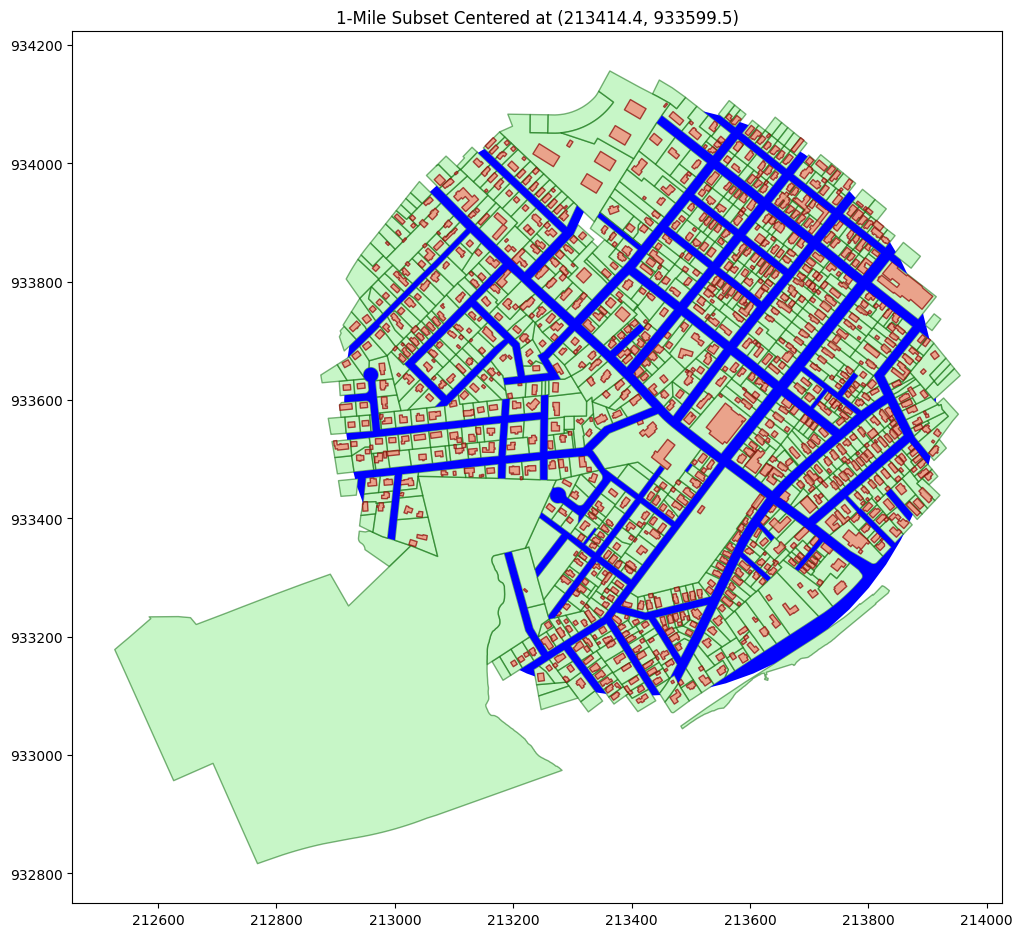

In [449]:
# Center point and buffer distance
center_x, center_y = 213414.4, 933599.5
buffer_feet = 500  # 1 mile in feet

# Create extraction area (circular buffer)
center_point = Point(center_x, center_y)
extraction_area = center_point.buffer(buffer_feet)

# Extract subsets
parcels_subset = parcels[parcels.intersects(extraction_area)].copy()
structures_subset = structures[structures.intersects(extraction_area)].copy()
row_subset = row[row.intersects(extraction_area)].copy()
row_subset = row_subset.clip(extraction_area)

# Reset indices
parcels_subset.reset_index(drop=True, inplace=True)
structures_subset.reset_index(drop=True, inplace=True)
row_subset.reset_index(drop=True, inplace=True)

print(f"Extracted subset sizes:")
print(f"  Structures: {len(structures_subset)}")
print(f"  Parcels: {len(parcels_subset)}")
print(f"  ROW: {len(row_subset)}")

# Quick visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
parcels_subset.plot(ax=ax, color='lightgreen', edgecolor='darkgreen', alpha=0.5)
structures_subset.plot(ax=ax, color='salmon', edgecolor='darkred', alpha=0.7)
row_subset.plot(ax=ax, color='blue', linewidth=2)
ax.set_title(f'1-Mile Subset Centered at ({center_x}, {center_y})')
ax.set_aspect('equal')
plt.show()

In [450]:
def compute_frontage_vectorized(
    parcels: gpd.GeoDataFrame,
    row: gpd.GeoDataFrame,
    buffer_distance_ft: float = 2,
    prefer: str = "percentage",  # or "length"
    simplify_tolerance: float | None = None,
    min_overlap_ft: float = 0.01
) -> gpd.GeoDataFrame:
    """
    Compute frontage for parcels using SPDBA-inspired reference points along ROW intersections.
    Returns segments_gdf with overlap info, front_type ('primary','secondary',None), 
    and a reference point along the frontage.
    """
    if parcels.crs is None or row.crs is None:
        raise ValueError("Both 'parcels' and 'row' must have a CRS set.")
    if parcels.crs != row.crs:
        row = row.to_crs(parcels.crs)

    # Determine units
    unit_name = getattr(parcels.crs, "axis_info", [None])[0].unit_name if getattr(parcels.crs, "axis_info", None) else None
    if unit_name in ("metre", "meter"):
        buffer_distance = buffer_distance_ft / METERS_TO_FEET
        to_feet = METERS_TO_FEET
    elif unit_name in ("US survey foot", "foot", "feet"):
        buffer_distance = buffer_distance_ft
        to_feet = 1.0
    else:
        raise ValueError(f"Parcels CRS unit is '{unit_name}'.")

    # --- Buffer ROW geometries ---
    row_buffer_individual = row.geometry.buffer(buffer_distance)
    row_buffer_union = _safe_union(row_buffer_individual)
    if simplify_tolerance:
        row_buffer_union = row_buffer_union.simplify(simplify_tolerance)
    row_buf_gdf = gpd.GeoDataFrame({"_": [1]}, geometry=[row_buffer_union], crs=parcels.crs)

    # --- Segmentize parcels ---
    all_segments = []
    parcel_ids = []
    loc_ids = []
    for idx, geom in zip(parcels.index, parcels.geometry):
        if isinstance(geom, MultiPolygon):
            geom = max(geom.geoms, key=lambda g: g.area)
        segs = _segments_from_boundary(geom.boundary)
        all_segments.extend(segs)
        parcel_ids.extend([idx] * len(segs))
        loc_ids.extend(parcels.loc[[idx], "LOC_ID"].tolist() * len(segs))

    segments_gdf = gpd.GeoDataFrame(
        {"parcel_id": parcel_ids, "LOC_ID": loc_ids},
        geometry=all_segments,
        crs=parcels.crs
    )
    segments_gdf["segment_length"] = shp_length(segments_gdf.geometry)

    # --- Compute overlaps ---
    try:
        cand_idx = segments_gdf.sindex.query(row_buffer_union, predicate="intersects")
        seg_candidates = segments_gdf.iloc[cand_idx].copy()
    except Exception:
        seg_candidates = gpd.sjoin(segments_gdf, row_buf_gdf, how="inner", predicate="intersects").drop(columns=["index_right"])

    segments_gdf["overlap_length"] = 0.0
    if not seg_candidates.empty:
        inter = seg_candidates.geometry.intersection(row_buffer_union)
        segments_gdf.loc[seg_candidates.index, "overlap_length"] = shp_length(inter)

    # Remove tiny slivers
    segments_gdf.loc[segments_gdf["overlap_length"] < (min_overlap_ft / to_feet), "overlap_length"] = 0.0

    # --- Compute percentages & units ---
    segments_gdf["overlap_percentage"] = (segments_gdf["overlap_length"] / segments_gdf["segment_length"]).fillna(0.0) * 100
    segments_gdf["segment_length_ft"] = segments_gdf["segment_length"] * to_feet
    segments_gdf["overlap_length_ft"] = segments_gdf["overlap_length"] * to_feet

    # --- Assign primary/secondary frontages with reference points ---
    segments_gdf['front_type'] = None
    # segments_gdf['ref_point'] = None

    SECONDARY_THRESHOLD = 90.0  # minimum % overlap for secondary frontage

    for pid, group in segments_gdf.groupby("parcel_id"):
        front_segs = group[group["overlap_length"] > 0]
        if front_segs.empty:
            continue

        # Primary = largest overlap
        primary_idx = front_segs['overlap_length'].idxmax()
        segments_gdf.loc[primary_idx, 'front_type'] = 'primary'
        seg = segments_gdf.loc[primary_idx].geometry
        # segments_gdf.loc[primary_idx, 'ref_point'] = seg.interpolate(0.5, normalized=True)

        # Secondary = if parcel has segment overlap >= threshold
        loc_id = group['LOC_ID'].iloc[0]
        secondary_candidates = front_segs.loc[front_segs.index.difference([primary_idx])]
        secondary_candidates = secondary_candidates[
            secondary_candidates['overlap_percentage'] >= SECONDARY_THRESHOLD
        ]
        for idx in secondary_candidates.index:
            segments_gdf.loc[idx, 'front_type'] = 'secondary'
            seg = segments_gdf.loc[idx].geometry
            # segments_gdf.loc[idx, 'ref_point'] = seg.interpolate(0.5, normalized=True)

    return segments_gdf, row_buf_gdf


In [451]:
def plot_frontage_segments(segments_gdf, parcels, row,  figsize=(10,10), buffer_alpha=0.2):
    """
    Plot parcels, ROW, front segments, and reference points for primary/secondary frontages.
    """
    import matplotlib.pyplot as plt

    # --- Plot ROW ---
    ax = row.plot(figsize=figsize, color='blue', alpha=buffer_alpha, label='ROW')

    # --- Plot parcel boundaries ---
    parcels.boundary.plot(ax=ax, color='black', linewidth=1.5, label='Parcel boundary')

    # --- Plot front segments ---
    # Primary frontages
    primary = segments_gdf[segments_gdf['front_type']=='primary']
    primary.plot(ax=ax, color='red', linewidth=1, label='Primary front')

    # Secondary frontages
    secondary = segments_gdf[segments_gdf['front_type']=='secondary']
    secondary.plot(ax=ax, color='orange', linewidth=1, label='Secondary front')

    ax.set_aspect('equal')
    ax.set_title("Parcels, ROW, Front Segments, and Reference Points")
    plt.legend()
    plt.show()


/var/folders/8r/d33ysv4j5v74p1wd2nt7sq1h0000gn/T/ipykernel_1947/1990586415.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


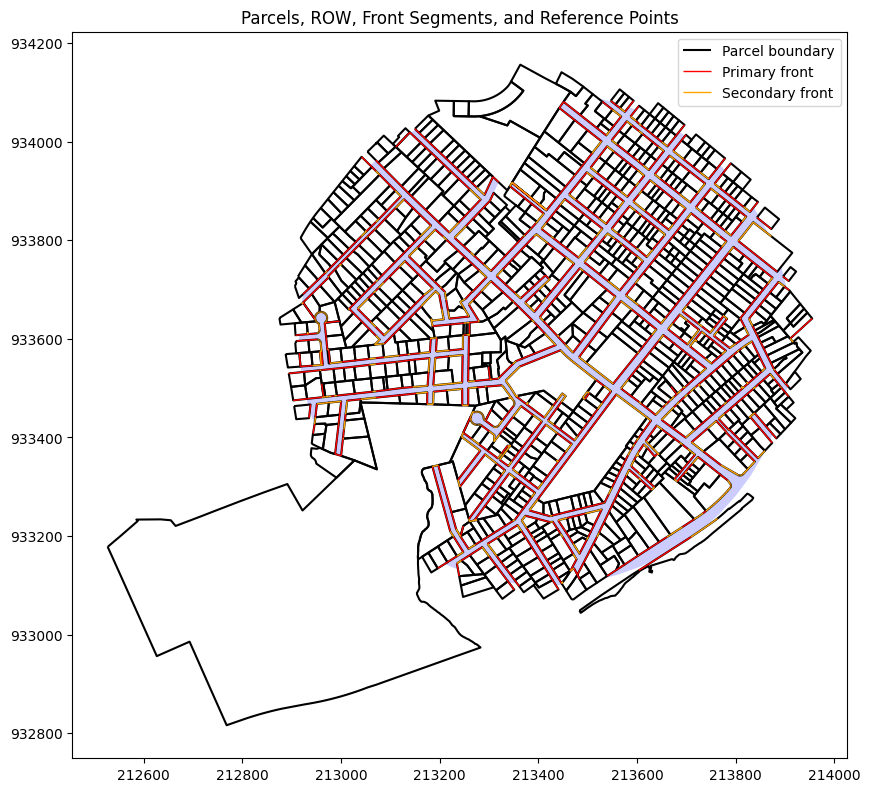

In [452]:
# Compute frontages with SPDBA reference points
segments_subset_gdf, row_subset_buf_gdf = compute_frontage_vectorized(
    parcels_subset,
    row_subset,
    buffer_distance_ft=15
)

# Plot everything
plot_frontage_segments(segments_subset_gdf, parcels_subset, row_subset)


In [454]:
# Compute frontages with SPDBA reference points
segments_gdf_all, row_buf_gdf = compute_frontage_vectorized(
    parcels,
    row,
    buffer_distance_ft=2
)

In [324]:
frontage = segments_gdf_all[segments_gdf_all['front_type']=='primary'].groupby('LOC_ID')['overlap_length_ft'].sum().reset_index()
frontage = frontage.rename(columns={'overlap_length_ft':'primary_frontage_ft'})
total_frontage = segments_gdf_all[segments_gdf_all['front_type']!= None].groupby('LOC_ID')['overlap_length_ft'].sum().reset_index()
total_frontage = total_frontage.rename(columns={'overlap_length_ft':'total_frontage_ft'})

# print(frontage)
parcels_data = parcels.merge(frontage, on='LOC_ID', how='left')
parcels_data = parcels_data.merge(total_frontage, on='LOC_ID', how='left')
parcels_data.columns
parcels_data[['primary_frontage_ft', 'total_frontage_ft']].describe()

,primary_frontage_ft,total_frontage_ft
count,20504.000000,21934.000000
mean,72.129053,123.208737
std,54.010796,154.031437
min,0.156695,0.000000
25%,44.320781,71.692837
50%,60.021192,94.585374
75%,89.089792,140.955340
max,1299.065115,7684.885933


In [325]:
duplicates = parcels_data[parcels_data.duplicated(subset=['LOC_ID'], keep=False)]
print(f"Found {len(duplicates)} duplicate LOC_IDs:")
print(duplicates['LOC_ID'].value_counts())

Found 0 duplicate LOC_IDs:
Series([], Name: count, dtype: int64)


In [346]:
parcels_data = parcels.copy()
parcels_data['lot_size_sf'] = parcels_data['acreage'] * 43560
parcels_data['lot_size_sf'].describe()

count    2.193400e+04
mean     1.396734e+04
std      6.756413e+04
min      1.593595e+01
25%      4.090155e+03
50%      6.392450e+03
75%      1.013763e+04
max      3.663014e+06
Name: lot_size_sf, dtype: float64

In [347]:
# calculate structures area
def calculate_building_area(parcels, structures):
    """
    Calculate building coverage for parcels based on actual overlapping area
    
    Parameters:
    parcels: GeoDataFrame with parcel polygons
    structures: GeoDataFrame with structure polygons
    
    Returns:
    pandas Series with total overlapping structure area per parcel in sq ft
    """
    
    # Ensure same CRS
    if parcels.crs != structures.crs:
        structures = structures.to_crs(parcels.crs)
        print("Reprojected structures to match parcels CRS")
    
    # Spatial join to find intersecting parcels and structures
    intersections = gpd.overlay(parcels, structures, how='intersection')
    
    # Calculate the area of each intersection in square feet
    if parcels.crs.axis_info[0].unit_name in ['metre', 'meter']:
        intersections['intersection_area_sq_ft'] = intersections.geometry.area * 10.7639  # m² to ft²
    else:
        intersections['intersection_area_sq_ft'] = intersections.geometry.area  # assume feet
    
    # Group by parcel and sum intersection areas
    coverage_summary = intersections.groupby('LOC_ID')['intersection_area_sq_ft'].sum()
    
    # Map back to all parcels (fill missing with 0)
    result = parcels['LOC_ID'].map(coverage_summary).fillna(0)
    
    return result


parcels_data['building_area_sq_ft'] = calculate_building_area(parcels_data, structures)
parcels_data['coverage_sh'] = parcels_data['building_area_sq_ft'] / parcels_data['lot_size_sf']

parcels_data['coverage_sh'].describe()

/Users/mckenziehumann/Documents/CommunityScale/Lowell/.venv/lib/python3.13/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


count    21934.000000
mean         0.245731
std          0.169222
min          0.000000
25%          0.133736
50%          0.216837
75%          0.334331
max          1.000001
Name: coverage_sh, dtype: float64

In [348]:
def measure_setbacks_hybrid(parcels, buildings, row):
    """
    Hybrid approach that handles both regular subdivisions and irregular parcels
    """
    # Ensure same CRS
    if parcels.crs != buildings.crs:
        buildings = buildings.to_crs(parcels.crs)
    if parcels.crs != row.crs:
        row = row.to_crs(parcels.crs)
    
    unit_multiplier = 3.28084 if parcels.crs.axis_info[0].unit_name in ['metre', 'meter'] else 1
    row_union = row.unary_union
    
    # Spatial join
    buildings_parcels = gpd.sjoin(buildings, parcels, how='left', predicate='intersects')
    buildings_parcels = buildings_parcels.dropna(subset=['index_right'])
    
    results = []
    
    for parcel_idx, group in buildings_parcels.groupby('index_right'):
        parcel = parcels.loc[parcel_idx]
        
        # Identify front, rear, and side boundaries
        front_boundary, rear_boundary, side_boundaries = identify_boundaries_hybrid(parcel.geometry, row_union)
        
        # Process buildings for this parcel
        for idx, building in group.iterrows():
            STRUCT_ID = building['STRUCT_ID']
            LOC_ID = building['LOC_ID']
            
            # Front setback
            front_distance = building.geometry.distance(front_boundary)
            
            # Rear setback
            if rear_boundary is not None:
                rear_distance = building.geometry.distance(rear_boundary)
            else:
                # Fallback: use entire parcel boundary
                rear_distance = building.geometry.distance(parcel.geometry.boundary)
            
            # Side setbacks
            if side_boundaries:
                side_distances = [building.geometry.distance(boundary) for boundary in side_boundaries]
                side_distances.sort()
                
                side1_distance = side_distances[0] if len(side_distances) > 0 else rear_distance
                side2_distance = side_distances[1] if len(side_distances) > 1 else rear_distance
            else:
                # Fallback: use boundary distance
                boundary_distance = building.geometry.distance(parcel.geometry.boundary)
                side1_distance = side2_distance = boundary_distance
            
            results.append({
                'STRUCT_ID': STRUCT_ID,
                'LOC_ID': LOC_ID,
                'front_setback_ft': front_distance * unit_multiplier,
                'side1_setback_ft': side1_distance * unit_multiplier,
                'side2_setback_ft': side2_distance * unit_multiplier,
                'rear_setback_ft': rear_distance * unit_multiplier,
                'min_side_setback_ft': min(side1_distance, side2_distance) * unit_multiplier
            })
    
    return pd.DataFrame(results)

def identify_boundaries_hybrid(parcel_geom, row_union):
    """
    Multi-method approach to identify front, rear, and side boundaries
    """
    boundary = parcel_geom.boundary
    
    # Method 1: Find boundary that intersects ROW buffer (for adjacent parcels)
    row_buffer = row_union.buffer(10)  # Small buffer for direct adjacency
    front_boundary = None
    
    if boundary.intersects(row_buffer):
        front_candidate = boundary.intersection(row_buffer)
        if not front_candidate.is_empty:
            front_boundary = front_candidate
    
    # Method 2: Find closest part of boundary to ROW (for separated parcels)
    if front_boundary is None:
        closest_point_on_boundary = nearest_points(boundary, row_union)[0]
        front_area = closest_point_on_boundary.buffer(20)  # Adjust size as needed
        front_boundary = boundary.intersection(front_area)
        
        if front_boundary.is_empty:
            front_boundary = boundary  # Fallback
    
    # Get remaining boundary after removing front
    remaining_boundary = boundary.difference(front_boundary.buffer(2))  # Small buffer for clean difference
    
    # Split remaining boundary into segments
    remaining_segments = []
    if hasattr(remaining_boundary, 'is_empty') and not remaining_boundary.is_empty:
        remaining_segments = split_boundary_into_segments(remaining_boundary)
    
    # Identify rear boundary as the segment furthest from ROW
    rear_boundary = None
    side_boundaries = []
    
    if remaining_segments:
        # Calculate distance of each segment to ROW
        distances_to_row = [seg.distance(row_union) for seg in remaining_segments]
        
        if distances_to_row:
            # Rear is the segment with maximum distance to ROW
            max_distance_idx = distances_to_row.index(max(distances_to_row))
            rear_boundary = remaining_segments[max_distance_idx]
            
            # Sides are the remaining segments
            side_boundaries = [seg for i, seg in enumerate(remaining_segments) if i != max_distance_idx]
    
    return front_boundary, rear_boundary, side_boundaries

def split_boundary_into_segments(boundary_geom):
    """
    Split boundary geometry into individual line segments or components
    """
    segments = []
    
    if boundary_geom.geom_type == 'MultiLineString':
        # Each LineString is a segment
        segments = list(boundary_geom.geoms)
    elif boundary_geom.geom_type == 'LineString':
        # Break into individual line segments if needed, or treat as single segment
        segments = [boundary_geom]
    elif boundary_geom.geom_type == 'GeometryCollection':
        # Extract LineString components
        for geom in boundary_geom.geoms:
            if geom.geom_type in ['LineString', 'MultiLineString']:
                if geom.geom_type == 'MultiLineString':
                    segments.extend(list(geom.geoms))
                else:
                    segments.append(geom)
    
    return segments

# Usage:
# setbacks = measure_setbacks_hybrid(parcels, buildings, row)

In [365]:
print(zoning.crs)
print(parcels_data.crs)

EPSG:26986
EPSG:26986


In [369]:
# Start fresh with the spatial join
# zoning = zoning.to_crs(parcels.crs)
parcels_zoning = gpd.sjoin(parcels_data, zoning, how="left", predicate='intersects')

print(f"After sjoin: {len(parcels_zoning)} records, {parcels_zoning['LOC_ID'].nunique()} unique parcels")

# Method 1: Simple - just keep first occurrence (fastest)
parcels_zoning_clean = parcels_zoning.drop_duplicates(subset=['LOC_ID'], keep='first')

# OR Method 2: Calculate actual intersection areas (more accurate but slower)
def get_largest_zone_overlap(group):
    if len(group) == 1:
        return group.iloc[0]
    
    parcel_geom = parcels_data[parcels_data['LOC_ID'] == group.iloc[0]['LOC_ID']].geometry.iloc[0]
    
    max_area = 0
    best_row = group.iloc[0]
    
    for idx, row in group.iterrows():
        zone_geom = zoning.loc[row['index_right'], 'geometry']
        intersection_area = parcel_geom.intersection(zone_geom).area
        if intersection_area > max_area:
            max_area = intersection_area
            best_row = row
    
    return best_row

# Apply the function to get largest overlap for each parcel
parcels_zoning_clean = parcels_zoning.groupby('LOC_ID').apply(get_largest_zone_overlap).reset_index(drop=True)
parcels_zoning_clean = parcels_zoning_clean.set_crs(zoning.crs, allow_override=True)

# Clean up columns
parcels_zoning_clean = parcels_zoning_clean.rename(columns={
    'ID': 'ZONING_ID', 
    'DESC_': 'ZONING_DESC', 
    'GlobalID': 'ZONING_GLOBAL_ID',
    'acreage': 'PARCEL_ACREAGE', 
    'Shape_Length': 'PARCEL_SHAPE_LEN', 
    'Shape_Area': 'PARCEL_SHAPE_AREA'
})
parcels_zoning_clean = parcels_zoning_clean.drop(columns=['index_right'], errors='ignore')

# Final check
print(f"Final result: {len(parcels_zoning_clean)} records, {parcels_zoning_clean['LOC_ID'].nunique()} unique parcels")
assert len(parcels_zoning_clean) == parcels_zoning_clean['LOC_ID'].nunique(), "Still have duplicates!"

parcels_zoning = parcels_zoning_clean

After sjoin: 27026 records, 21934 unique parcels
Final result: 21934 records, 21934 unique parcels


/var/folders/8r/d33ysv4j5v74p1wd2nt7sq1h0000gn/T/ipykernel_1947/2209394443.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  parcels_zoning_clean = parcels_zoning.groupby('LOC_ID').apply(get_largest_zone_overlap).reset_index(drop=True)


In [370]:
print(parcels_zoning.crs)

EPSG:26986


In [371]:
parcels_zoning['i_sf'] = parcels_zoning['UseDesc'].str.contains('Single-family', na=False)
parcels_zoning['i_res'] = parcels_zoning['residentialunits']>0
parcels_zoning['i_3fam'] = parcels_zoning['UseDesc'].str.contains('family', na=False)

parcels_zoning['Use_Type'] = 'all_permitted'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'SMF') & (parcels_zoning['i_3fam']), 'Use_Type'] = '3fam'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'SMF') & ~(parcels_zoning['i_3fam']), 'Use_Type'] = 'not_3fam'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'SMU') & (parcels_zoning['i_3fam']), 'Use_Type'] = '3fam'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'SMU') & (parcels_zoning['i_res']) & ~(parcels_zoning['i_3fam']), 'Use_Type'] = 'res_not_3fam'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'SMU') & ~(parcels_zoning['i_res']), 'Use_Type'] = 'not_res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TTF') & (parcels_zoning['i_sf']), 'Use_Type'] = 'sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TTF') & ~(parcels_zoning['i_sf']), 'Use_Type'] = 'not_sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TMF') & (parcels_zoning['i_sf']), 'Use_Type'] = 'sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TMF') & ~(parcels_zoning['i_sf']), 'Use_Type'] = 'not_sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TMU') & (parcels_zoning['i_sf']),'Use_Type'] = 'sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TMU') & ~(parcels_zoning['i_sf']) & (parcels_zoning['i_res']),'Use_Type'] = 'res_not_sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'TMU') & ~(parcels_zoning['i_res']),'Use_Type'] = 'not_res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'NB') & (parcels_zoning['i_res']),'Use_Type'] = 'res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'NB') & ~(parcels_zoning['i_res']),'Use_Type'] = 'not_res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'USF') & (parcels_zoning['i_sf']),'Use_Type'] = 'sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'USF') & ~(parcels_zoning['i_sf']),'Use_Type'] = 'not_sf'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'UMU') & (parcels_zoning['i_res']),'Use_Type'] = 'res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'UMU') & ~(parcels_zoning['i_res']),'Use_Type'] = 'not_res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'HRC') & (parcels_zoning['i_res']),'Use_Type'] = 'res'
parcels_zoning.loc[(parcels_zoning['ZONE'] == 'HRC') & ~(parcels_zoning['i_res']),'Use_Type'] = 'not_res'

parcels_zoning = parcels_zoning.merge(zoning_df, on=['ZONE', 'Use_Type'], how='outer')


In [372]:
parcels_zoning['ZONE'].value_counts()

ZONE
SSF     5706
TTF     5065
TSF     4984
TMF     2023
USF      880
UMU      578
TMU      526
UMF      461
DMU      364
LI       307
NB       248
RR       208
SMF      195
INST     122
SMU       88
GI        81
HCD       39
HRC       37
OP        21
PDMI       1
Name: count, dtype: int64

In [373]:
parcels_zoning.columns

Index(['OBJECTID_1', 'LOC_ID', 'LAST_EDIT', 'TOWN_ID', 'SiteAddress', 'City',
       'AssessedYear', 'PARCEL_ACREAGE', 'StandardizedUseCodes', 'UseDesc',
       'NonResidentialUses', 'AssessorUseDesc', 'residentialunits',
       'unitsource', 'DUA', 'Developable', 'PARCEL_SHAPE_LEN',
       'PARCEL_SHAPE_AREA', 'geometry', 'lot_size_sf', 'building_area_sq_ft',
       'coverage_sh', 'ZONING_ID', 'ZONE', 'ZONING_DESC', 'ZONING_GLOBAL_ID',
       'Shape_STAr', 'Shape_STLe', 'i_sf', 'i_res', 'i_3fam', 'Use_Type',
       'Max_FAR', 'Min_Lot_Size_SF', 'Min_LA_per_DU_SF', 'Min_Frontage_FT',
       'Setback_Existing_Block', 'Min_Front_Setback_FT',
       'Max_Front_Setback_FT', 'Projections_Setback_FT', 'Porches_Setback_FT',
       'Garages_Setback_FT', 'Min_Side_Yard', 'Min_Combined_Side_Yard',
       'Min_Rear_Yard_FT', 'Min_UOS_per_DU_SF', 'Max_Height_FT',
       'Max_Stories'],
      dtype='object')

In [374]:
parcels_zoning['lot_area_per_du'] = parcels_zoning['lot_size_sf'] / parcels_zoning['residentialunits']
parcels_zoning['uos_per_du'] = (parcels_zoning['lot_size_sf'] * (1 - parcels_zoning['coverage_sh']) ) / parcels_zoning['residentialunits']

parcels_zoning['Min_LA_per_DU_SF'] = parcels_zoning['Min_LA_per_DU_SF'].fillna(0)
parcels_zoning['Min_Lot_Size_SF'] = parcels_zoning['Min_Lot_Size_SF'].fillna(0)
parcels_zoning['Min_UOS_per_DU_SF'] = parcels_zoning['Min_UOS_per_DU_SF'].fillna(0)
# parcels_zoning['Min_Frontage_FT'] = parcels_zoning['Min_Frontage_FT'].fillna(0)

parcels_zoning['ncf_min_lot_area_per_du'] = (parcels_zoning['lot_area_per_du'] < parcels_zoning['Min_LA_per_DU_SF']).astype(int)
parcels_zoning['ncf_min_lot_size'] = (parcels_zoning['lot_size_sf'] < parcels_zoning['Min_Lot_Size_SF']).astype(int)
parcels_zoning['ncf_min_uos_per_du'] = (parcels_zoning['uos_per_du'] < parcels_zoning['Min_UOS_per_DU_SF']).astype(int)
# parcels_zoning['ncf_min_frontage'] = (parcels_zoning['total_frontage_ft'] < parcels_zoning['Min_Frontage_FT']).astype(int)

In [375]:
# Or if you want specific variables only:
variables_of_interest = [
    'lot_area_per_du', 
    'uos_per_du', 
    'lot_size_sf'
    # 'total_frontage_ft'
]

# If you want to reset index to make ZONE a column again:
percentiles_multiple = parcels_zoning.groupby('ZONE')[variables_of_interest].quantile([0.75, 0.85, 0.95])
percentiles_wide = percentiles_multiple.unstack(level=-1)

percentiles_wide

lot_area_per_du                       uos_per_du                     \
                0.75          0.85 0.95          0.75          0.85 0.95   
ZONE                                                                       
DMU              NaN           NaN  NaN           NaN           NaN  NaN   
GI               inf           inf  inf           inf           inf  inf   
HCD              NaN           NaN  NaN           NaN           NaN  NaN   
HRC              inf           NaN  NaN           inf           NaN  NaN   
INST             NaN           NaN  NaN           NaN           NaN  NaN   
LI               NaN           NaN  NaN           NaN           NaN  NaN   
NB               NaN           NaN  NaN           NaN           NaN  NaN   
OP               inf           inf  inf           inf           inf  inf   
PDMI             inf           inf  inf           inf           inf  inf   
RR               NaN           NaN  NaN           NaN           NaN  NaN   
SMF              NaN           NaN  NaN           NaN           NaN  NaN   
SMU              NaN           NaN  NaN           NaN           NaN  NaN   
SSF     1.470121e+04  2.097764e+04  NaN  1.285256e+04  1.919869e+04  NaN   
TMF     4.107403e+03  6.807440e+03  NaN  2.978296e+03  5.307956e+03  NaN   
TMU              NaN           NaN  NaN           NaN           NaN  NaN   
TSF     8.632638e+03  1.118085e+04  NaN  7.165806e+03  9.649770e+03  NaN   
TTF     4.780414e+03  6.607481e+03  NaN  3.665073e+03  5.269065e+03  NaN   
UMF              inf           inf  inf           inf           inf  inf   
UMU              NaN           NaN  NaN           NaN           NaN  NaN   
USF     3.088350e+03  3.896988e+03  NaN  2.094626e+03  2.824756e+03  NaN   

       lot_size_sf                              
              0.75          0.85          0.95  
ZONE                                            
DMU   1.618604e+04  3.202885e+04  8.822611e+04  
GI    5.515357e+04  8.319002e+04  1.839720e+05  
HCD   2.244218e+04  3.143253e+04  6.394560e+04  
HRC   3.401234e+05  3.899358e+05  5.704392e+05  
INST  5.266423e+04  9.639106e+04  2.441867e+05  
LI    4.776599e+04  1.070968e+05  2.485733e+05  
NB    9.638076e+03  1.308730e+04  2.441247e+04  
OP    1.749481e+05  2.438428e+05  3.428426e+05  
PDMI  2.839689e+06  2.839689e+06  2.839689e+06  
RR    4.002354e+04  6.501424e+04  1.461450e+05  
SMF   4.420109e+04  8.995694e+04  2.482942e+05  
SMU   8.342845e+04  1.521971e+05  3.557908e+05  
SSF   1.335125e+04  1.645408e+04  2.970382e+04  
TMF   7.458244e+03  1.003583e+04  1.926887e+04  
TMU   9.602292e+03  1.510564e+04  3.133758e+04  
TSF   8.361131e+03  1.014488e+04  1.481280e+04  
TTF   6.552121e+03  7.949700e+03  1.169808e+04  
UMF   5.571899e+03  7.530530e+03  1.753547e+04  
UMU   8.295449e+03  1.299724e+04  3.225528e+04  
USF   3.315373e+03  4.049429e+03  6.153688e+03

In [376]:
cf_analysis = parcels_zoning.groupby('ZONE').agg(
    total_parcels = ('LOC_ID', 'count'),
    total_residential_parcels = ('i_res', 'sum'),
    share_residential=('i_res', 'mean'),
    share_ncf_min_lot_area_per_du = ('ncf_min_lot_area_per_du', 'mean'),
    share_ncf_min_lot_size = ('ncf_min_lot_size', 'mean'),
    share_ncf_min_uos_per_du = ('ncf_min_uos_per_du', 'mean')
    # share_ncf_min_frontage = ('ncf_min_frontage', 'mean')
).reset_index()

cf_analysis

,ZONE,total_parcels,total_residential_parcels,share_residential,share_ncf_min_lot_area_per_du,share_ncf_min_lot_size,share_ncf_min_uos_per_du
0,DMU,364,70,0.192308,0.000000,0.000000,0.027473
1,GI,81,0,0.000000,0.000000,0.000000,0.000000
2,HCD,39,3,0.076923,0.000000,0.000000,0.000000
3,HRC,37,3,0.081081,0.000000,0.054054,0.000000
4,INST,122,22,0.180328,0.000000,0.000000,0.008197
5,LI,307,43,0.140065,0.000000,0.000000,0.000000
6,NB,248,67,0.270161,0.221774,0.181452,0.088710
7,OP,21,1,0.047619,0.000000,0.000000,0.000000
8,PDMI,1,0,0.000000,0.000000,0.000000,0.000000
9,RR,208,23,0.110577,0.000000,0.000000,0.000000


In [377]:
zoning_df

,ZONE,Use_Type,Max_FAR,Min_Lot_Size_SF,Min_LA_per_DU_SF,Min_Frontage_FT,Setback_Existing_Block,Min_Front_Setback_FT,Max_Front_Setback_FT,Projections_Setback_FT,Porches_Setback_FT,Garages_Setback_FT,Min_Side_Yard,Min_Combined_Side_Yard,Min_Rear_Yard_FT,Min_UOS_per_DU_SF,Max_Height_FT,Max_Stories
0,SSF,all_permitted,0.35,10000.0,10000.0,90,0,25.0,NaN,22.0,17.0,30.0,10.0,25.0,25.0,750.0,35.0,2.5
1,SMF,3fam,0.75,20000.0,10000.0,90,0,25.0,NaN,NaN,NaN,30.0,20.0,NaN,25.0,750.0,40.0,3.0
2,SMF,not_3fam,0.75,20000.0,3000.0,40,0,25.0,NaN,NaN,NaN,30.0,20.0,NaN,25.0,750.0,40.0,3.0
3,SMU,3fam,2.00,20000.0,10000.0,90,0,25.0,NaN,NaN,NaN,30.0,20.0,NaN,25.0,750.0,40.0,3.0
4,SMU,res_not_3fam,2.00,20000.0,3000.0,40,0,25.0,NaN,NaN,NaN,30.0,20.0,NaN,0.0,300.0,NaN,NaN
5,SMU,not_res,2.00,NaN,NaN,25,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
6,RR,all_permitted,2.00,NaN,NaN,25,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,40.0,NaN,NaN,NaN
7,TSF,all_permitted,0.35,7000.0,7000.0,70,0,15.0,20.0,12.0,9.0,24.0,10.0,25.0,20.0,300.0,32.0,2.5
8,TTF,sf,NaN,6000.0,6000.0,70,0,15.0,20.0,12.0,9.0,24.0,10.0,NaN,20.0,500.0,32.0,2.5
9,TTF,not_sf,NaN,6000.0,4000.0,80,0,15.0,20.0,12.0,9.0,24.0,10.0,25.0,20.0,500.0,35.0,2.5


In [378]:
# Check if LOC_ID has duplicates
duplicates = parcels_zoning[parcels_zoning.duplicated(subset=['LOC_ID'], keep=False)]
print(f"Found {len(duplicates)} duplicate LOC_IDs:")
print(duplicates['LOC_ID'].value_counts())

Found 0 duplicate LOC_IDs:
Series([], Name: count, dtype: int64)


In [388]:
land_use_codes = pd.read_csv("nonconformity_analysis/Mass Land Use Codes.csv")
land_use_codes['Land Use Code'] = land_use_codes['Land Use Code'].astype(str)
land_use_codes = land_use_codes.rename(columns={'Land Use Code':'UseCode',
                                                  'Official Category':'UseDescFull',
                                                  'Category Name':'UseCategory'})
land_use_codes = land_use_codes[['UseCode', 'UseDescFull', 'UseCategory']]

In [402]:
parcels_zoning['primary_land_use'] = parcels_zoning['StandardizedUseCodes'].str.split(';').str[0]
parcels_zoning_all = parcels_zoning.merge(land_use_codes, left_on='primary_land_use', right_on='UseCode', how='left')
parcels_zoning_all.loc[(parcels_zoning_all['UseDesc'].str.contains('Commercial') & parcels_zoning_all['UseCategory'].isna()), 'UseCategory'] = 'Commercial'
parcels_zoning_all.loc[(parcels_zoning_all['UseDesc'].str.contains('Industrial') & parcels_zoning_all['UseCategory'].isna()), 'UseCategory'] = 'Industrial, auto, utility, storage'
parcels_zoning_all['UseCategory'] = parcels_zoning_all['UseCategory'].fillna('Unknown use')
parcels_zoning_all['UseCategory'].value_counts()

UseCategory
Single-family                                  11911
Two-family                                      3717
Unknown use                                     1341
Multi-family                                    1090
Commercial                                      1086
Three-family                                     805
Other housing                                    777
Public/Institutional (including open space)      508
Industrial, auto, utility, storage               350
Vacant                                           349
Name: count, dtype: int64

In [404]:
parcels_zoning_all['res_lot_size_sf'] = np.where(
    parcels_zoning_all['i_res'], 
    parcels_zoning_all['lot_size_sf'], 
    np.nan
)

parcels_zoning_all['res_ncf_min_lot_size'] = np.where(
   parcels_zoning_all['i_res'], 
    parcels_zoning_all['ncf_min_lot_size'], 
    0
)

parcels_zoning_all['res_ncf_min_lot_area_per_du'] = np.where(
    parcels_zoning_all['i_res'], 
    parcels_zoning_all['ncf_min_lot_area_per_du'], 
    0
)

parcels_zoning_all['res_ncf_min_uos_per_du'] = np.where(
    parcels_zoning_all['i_res'], 
    parcels_zoning_all['ncf_min_uos_per_du'], 
    0
)

parcels_output = parcels_zoning_all[['LOC_ID', 'SiteAddress','ZONE', 'res_lot_size_sf',  'residentialunits', 'lot_area_per_du', 'res_ncf_min_lot_size', 'ncf_min_lot_size','res_ncf_min_lot_area_per_du','res_ncf_min_uos_per_du', 'UseCategory', 'geometry']]

columns_to_convert = ['LOC_ID', 'ZONE', 'residentialunits', 'lot_area_per_du', 
                     'res_ncf_min_lot_size', 'ncf_min_lot_size', 
                     'res_ncf_min_lot_area_per_du', 'res_ncf_min_uos_per_du']

parcels_output[columns_to_convert] = parcels_output[columns_to_convert].astype(str)

parcels_output = parcels_output.to_crs(mapbox_crs)
parcels_output.to_file("../Lowell-git/allparcels.geojson", driver="GeoJSON")

/Users/mckenziehumann/Documents/CommunityScale/Lowell/.venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [401]:
parcels_zoning[parcels_zoning['UseDesc'].str.contains('Industrial')]

,OBJECTID_1,LOC_ID,LAST_EDIT,TOWN_ID,SiteAddress,City,AssessedYear,PARCEL_ACREAGE,StandardizedUseCodes,UseDesc,...,lot_area_per_du,uos_per_du,ncf_min_lot_area_per_du,ncf_min_lot_size,ncf_min_uos_per_du,res_lot_size_sf,res_ncf_min_lot_size,res_ncf_min_lot_area_per_du,res_ncf_min_uos_per_du,primary_land_use
11,1338279,F_706126_3057956,20110720,160,274 Appleton Street,Lowell,2025,0.245448,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
28,1449278,F_706465_3058589,20110720,160,259 Middlesex Street,Lowell,2025,0.581474,,Commercial; Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
54,1874945,F_706658_3059647,20200227,160,246.1 Market St,Lowell,2025,0.743099,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
72,1454580,F_706790_3058713,20110720,160,179 Middlesex Street,Lowell,2025,0.122400,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
78,1463280,F_706831_3058732,20110720,160,169 Middlesex Street,Lowell,2025,0.048047,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20708,892014,F_706544_3056151,20110720,160,4 Lowell Connector,Lowell,2025,0.087526,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
20743,1451320,F_707216_3058603,20110720,160,115 Appleton Street,Lowell,2025,0.293310,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
20745,1457468,F_707358_3058664,20110720,160,91 Appleton Street,Lowell,2025,0.405197,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
20812,1624387,F_709118_3061424,20110720,160,39 First Street Boulevard,Lowell,2025,0.822797,,Industrial,...,inf,inf,0,0,0,NaN,0,0,0,
